# Assignment 4: PCA

Due: Thursday, October 24 at midnight

In this assignment you'll gain some hands-on experience with principal components analysis (PCA).

The assignment has three problems. The first problem investigates PCA and linear regression on a simple toy data set. The second two problems use the MNIST and Fashion MNIST data, and the database of faces that we began looking at during last week's lectures. In the second problem, you will study how different numbers of principal components represent the images visually. For third problem you will use logistic regression to predict the class label of images using the principal components representation of the images, and examine how the classification error changes with the number of principal components used. 

For the second two problems, once you get your code to work on MNIST, it should be straightforward to just copy paste the code and then run it on Fashion MNIST and the face data. 

Please submit your notebook and pdf (from html) following the usual instructions.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem 1: Principal components and Least squares

In least-squares regression one of the assumptions made is that the explanatory variable(s) are non-random and contain no measurement error. Therefore, the size of the residuals (vertical distances between each observed values of the response variable and the line) completely characterize the loss due to a given line. However, it is often the case that explanatory variables do have some randomness in them, in which case we may wish to characterize the loss with the orthogonal distances between data points and the line. This can be done with what is called Principal Component Regression, which you will have some time to use in this problem.

## Part (a)

The cell below simulates two indepndent random variables, each from a Normal distribution with mean $0$. It then rotates the data by an angle $\dfrac{\pi}{3}$. What is the slope and intercept of a horizontal line after it has been rotated about the origin by $\dfrac{\pi}{3}$ radians? Add a line with this slope and intercept to the plot generated in the following cell.

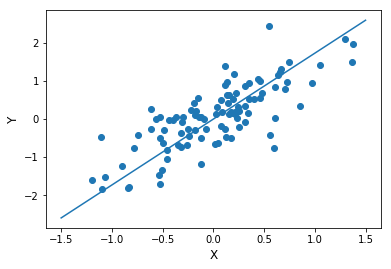

In [2]:
np.random.seed(10)
X = np.vstack((np.random.normal(0, 1, size=100), np.random.normal(0, 0.3, size=100))).T

theta = np.pi/3
R = np.array([np.cos(theta), np.sin(theta), -np.sin(theta), np.cos(theta)]).reshape(2,2)
X = np.dot(X, R)

plt.scatter(np.array(X[:,0]), np.array(X[:,1]))
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

x = np.linspace(-1.5, 1.5, 1000)
plt.plot(x, np.sqrt(3)*x)
plt.show()

When the line $y=0$ is rotated by 60º, it results in a line with slope $\sqrt{3}$ and intercept zero. Thus, the line is $y=\sqrt{3}x$

## Part (b)

Use least-squares regression to fit a line (with a slope and intercept) to the data generated above. Create a plot that displays the data, the true line, and the least-squares regression line. Be sure to label the two lines with legends in your plot!

You could use `statsmodels.api.OLS` to fit the "ordinary least-squares" regression, or any other function of your choice.


In [3]:
import statsmodels.api as sm

lm1 = sm.OLS(np.array(X[:,1]), np.array(X[:,0]))
results = lm1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     155.6
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           5.07e-22
Time:                        02:13:54   Log-Likelihood:                -79.995
No. Observations:                 100   AIC:                             162.0
Df Residuals:                      99   BIC:                             164.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2673      0.102     12.472      0.0

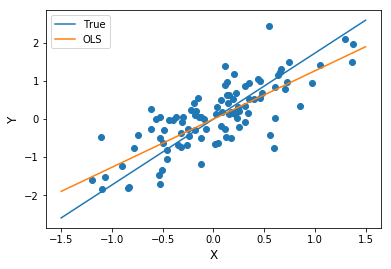

In [4]:
plt.scatter(np.array(X[:,0]), np.array(X[:,1]))
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

x = np.linspace(-1.5, 1.5, 1000)
plt.plot(x, np.sqrt(3)*x, label='True')
plt.plot(x, 1.2673*x, label='OLS')
plt.legend(loc='upper left')

plt.show()

## Part (c)

Now fit a line to the data by projecting onto the first principal component. What is the slope of the line created by the first principal component, and how does it relate to the true slope? Create a plot with all three lines, including those you constructed in parts (a) and (b). 

The slope of the line made by PCA is 1.8232, slightly higher than the true slope by 5%.

In [5]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
principal_vectors = pca.components_
print(principal_vectors[0][1]/principal_vectors[0][0])

NameError: name 'X' is not defined

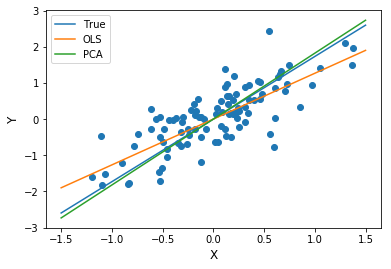

In [6]:
plt.scatter(np.array(X[:,0]), np.array(X[:,1]))
plt.xlabel("X", fontsize=12)
plt.ylabel("Y", fontsize=12)

x = np.linspace(-1.5, 1.5, 1000)
plt.plot(x, np.sqrt(3)*x, label='True')
plt.plot(x, 1.2673*x, label='OLS')
plt.plot(x, 1.8232*x, label='PCA')
plt.legend(loc='upper left')

plt.show()

## Part (d)

Explain why least-squares regression and principal components analysis give different fits to the data in part (c)? 
Can you say that one fit is better than the other?

PCA aims to choose a component that captures the most variability in the data, while OLS aims to minimize the squared residuals of the data from the fitted values. Geometrically, PCA uses the perpendicular distance from the line to the data to measure its fit, while OLS uses vertical distance, and we see that this will result in different fits on the data. I think we can't say one fits the data better than the other, as both models are giving the most optimal fit given their definitions of "fitting the data", and an optimal model will depend on our own definitions of "fit".

## Problems 2 and 3: MNIST and  Fashion MNIST data


For the next two problems you will need the MNIST and Fashion MNIST data. You can download these data sets here:

MNIST   http://yann.lecun.com/exdb/mnist/<br>
FASHION-MNIST    https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

Download the following files:<br>
train-images-idx3-ubyte.gz<br>
train-labels-idx1-ubyte.gz<br>
t10k-images-idx3-ubyte.gz<br>
t10k-labels-idx1-ubyte.gz

To run the code, put the data in directories named `mnist` and `fashion-mnist` within the same directory as this notebook. 

### The following "helper functions" should be used to read in the MNIST and Fashion MNIST datasets.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, gzip

def load_data(dataset_name):
    data_dir = os.path.join("./", dataset_name)
        
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 409
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)
    return X / 255., y    

# Problem 2: PCA for Dimension Reduction

In this problem you will approximately reconstruct images by simplifying them to multiples of a few principal components.

Note: When you display the images, use the color map `cmap=plt.cm.gray.reversed()` for MNIST and Fashion MNIST and use `cmap=plt.cm.gray` for the face data

## Part (a)

Pick a random seed in the next cell to select a random image of a handwritten $0$ from the MNIST data.

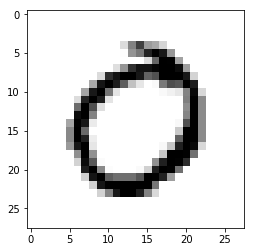

In [3]:
#Reading data
x, y = load_data('mnist')
x = x.reshape([70000, 28*28]) #Turns array of entries into 28x28 matrix
zeros = np.where(y==0)[0] #Take the images of "0"s
x = x[zeros,:]
y = y[zeros]

#Subtracting the mean
avgimg = x.mean(0)
cimages = np.subtract(x, avgimg)

#Choose the image
np.random.seed(0) 
my_image = np.random.randint(0, len(y), size=1) #Index of Random Image to Show
plt.imshow(x[my_image,:].reshape((28,28)), cmap=plt.cm.gray.reversed()) 

For $k = 0, 10, 20, ...,100$, use $k$ principal components for MNIST $0$'s to approximately reconstruct the image selected above. Display the reconstruction for each value of $k$. To display the set of images compactly, you may want to use subplot, as shown in the starter code for Problem 3(b) below.

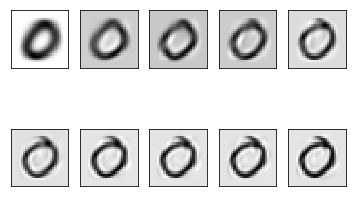

In [9]:
for i in range(10):
    plt.subplot(2, 5, i + 1) #Create 2x5 plot, Filled Row by Row using Index (i+1)
    pca = PCA(i*10).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i*10, 28, 28)) #Reshape components into matrix
    pcs = pca.fit_transform(cimages)
    capprox = pca.inverse_transform(pcs)
    approx = np.add(capprox[my_image],avgimg)
    plt.imshow(approx.reshape((28, 28)), cmap=plt.cm.gray.reversed())
    plt.xticks(())
    plt.yticks(())

We see that as we increase the number of components, the image becomes sharper, and it also increasingly resembles the image we showed in the previous code chunk. The tail sticking out above the 0 becomes more pronounced, and the body of the 0 is less fat. This agrees with what we expect from adding more components that explain variability in 0's, and thereby improve our rendering of an individual image.

## Part (b)

Repeat Part (a), but this time for the dresses in the Fashion-MNIST dataset.

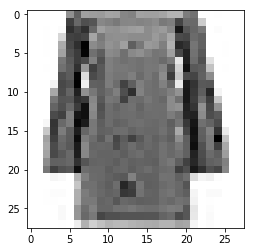

In [10]:
x, y = load_data('fashion-mnist')
x = x.reshape([70000, 28*28])
zeros = np.where(y==3)[0]
x = x[zeros,:]
y = y[zeros]
np.random.seed(0) #put your seed here
my_image = np.random.randint(0, len(y), size=1)

plt.imshow(x[my_image,:].reshape((28,28)), cmap=plt.cm.gray.reversed())

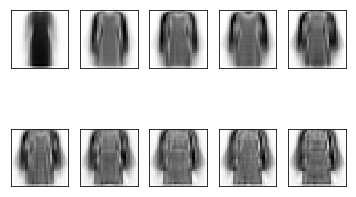

In [11]:
#Subtracting the mean
avgimg = x.mean(0)
cimages = np.subtract(x, avgimg)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    pca = PCA(i*10).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i*10, 28, 28))
    pcs = pca.fit_transform(cimages)
    capprox = pca.inverse_transform(pcs)
    approx = np.add(capprox[my_image],avgimg)
    plt.imshow(approx.reshape((28, 28)), cmap=plt.cm.gray.reversed())
    plt.xticks(())
    plt.yticks(())

Like part a, the image becomes sharper and more accurate, as expected when adding more components that explain variability in the dresses and improve a dress' rendering.

## Part (c)

Do the same thing as in Parts (a) and (b), this time reconstructing an image of Gerhard Schroeder.

In [12]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=10, resize=0.4)
[index for index,item in enumerate(lfw_people.target_names=='Gerhard Schroeder') if item]

[36]

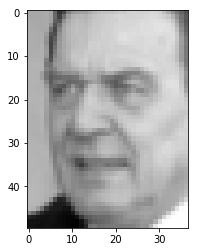

In [13]:
x = lfw_people.data
y = lfw_people.target
zeros = np.where(y==36)[0]
x = x[zeros,:]
y = y[zeros]
np.random.seed(0) #put your seed here
my_image = np.random.randint(0, len(y), size=1)

plt.imshow(x[my_image,:].reshape((50,37)), cmap=plt.cm.gray)#, cmap=plt.cm.gray.reversed())

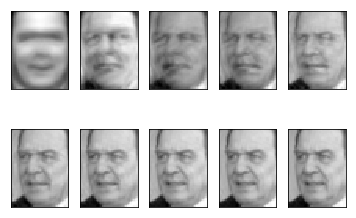

In [14]:
#Subtracting the mean
avgimg = x.mean(0)
cimages = np.subtract(x, avgimg)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    pca = PCA(i*10).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i*10, 50, 37))
    pcs = pca.fit_transform(cimages)
    capprox = pca.inverse_transform(pcs)
    approx = np.add(capprox[my_image],avgimg)
    plt.imshow(approx.reshape((50, 37)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

We have similar observations and reasoning as in a and b for the rendering of the image of Gerhard Schroeder.

# Problem 3: PCA for Classification

## Part (a)

Load in the MNIST data with the labels as `y` and the images as `x` by running the next cell. Create a subset of the data by keeping only the images that have the label of either $4$ or $9$. Use Principal Components Analysis (PCA) to project the data onto the first two principal components, and create a plot of the projected data color-coded by the label. Does the plot make sense? Explain in a couple sentences.

Text(0, 0.5, 'Component 2')

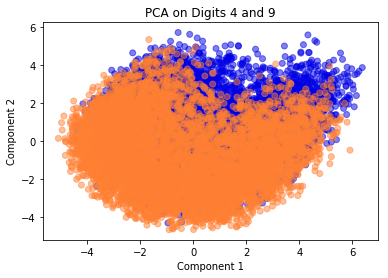

In [15]:
from sklearn.linear_model import LogisticRegression

x, y = load_data('mnist')
x = x.reshape([70000, 28*28])

indices = []
for item in np.where(y==4)[0]:
    indices.append(item)
for item in np.where(y==9)[0]:
    indices.append(item)

x = x[indices,:]
y = y[indices]

#Subtracting the Mean
avgimg = x.mean(0)
cimages = np.subtract(x, avgimg)

#Running the PCA
pca = PCA(2).fit(cimages)
principal_vectors = pca.components_
principal_vectors = principal_vectors.reshape((2, 28, 28))

#Writing Data on New PCA Axes
pcs = pca.fit_transform(cimages)

colors = []
for item in y:
    if item==9:
        colors.append((1,0.5,0.2,0.5)) #orange
    elif item==4:
        colors.append((0.0,0.0,0.9,0.5)) #blue

#Plot
plt.scatter(pcs[:,0],pcs[:,1], color = colors)
plt.title('PCA on Digits 4 and 9')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

The plot shows 9's in orange and 4's in blue. We see that although the numbers are grouped amongst themselves, their plots are overlapping. This means that the 2 components are not enough to sufficiently differentiate the two.

## Part (b)

Why not use more principal components! For $k = 2,3,4,...,15$, use PCA to project the data onto $k$ principal components. For each $k$, use logistic regression to build a model to classify images as $4$ or $9$, and calculate the misclassification rate. Create a plot of misclassification rate as a function of $k$, the number of principal components used. Does the plot make sense? Explain.

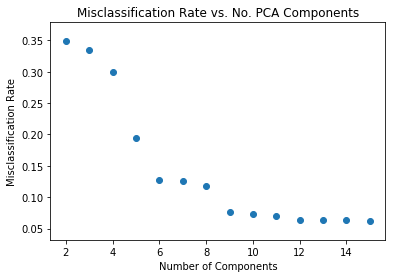

In [16]:
misClass = []
for i in range(2,16):
    #Running the PCA
    pca = PCA(i).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i, 28, 28))

    #Writing Data on New PCA Axes
    pcs = pca.fit_transform(cimages)
    
    #Remember to Subtract Score from 1 to Obtain Misclassification Rate
    logReg = LogisticRegression(solver='lbfgs').fit(pcs, y)
    misClass.append(1-logReg.score(pcs,y))
    
plt.scatter(range(2,16),misClass)
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. No. PCA Components')
plt.show()

The plot shows that as we increase the number of components, the misclassification rate goes down, and approaches 0.05. This makes sense because increasing the number of components captures more of the variability in the data, and this will give more information upon which to distinguish the 4's from the 9's. As a result, the model gets better at classifying the data. It does not reach 0 however since it is understandable that given how 4's and 9's are similar in shape, and so there will be numbers the model cannot distinguish, thus it is difficult to reach 0% error.

## Part (c)

Build a logistic regression model using $10$ principal components. Create a list called `misclass` that lists the indices of all images that were misclassified with this model. Run the cell below to create a visualization of the first $16$ of these images. Does it make sense that these would be hard to classify correctly?

In [17]:
#Running the PCA
pca = PCA(10).fit(cimages)
principal_vectors = pca.components_
principal_vectors = principal_vectors.reshape((10, 28, 28))

#Writing Data on New PCA Axes
pcs = pca.fit_transform(cimages)

logReg = LogisticRegression(solver='lbfgs').fit(pcs, y)
logPred = logReg.predict(pcs)

misclass = [index for index,value in enumerate(y==logPred) if value==False]

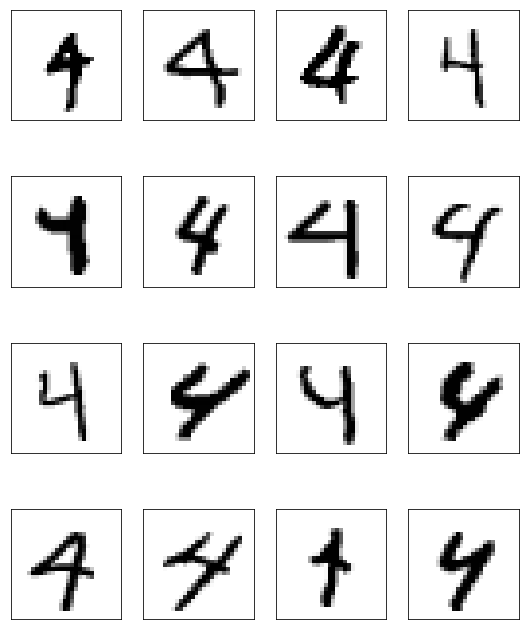

In [18]:
# The following code will display the images that are misclassified
plt.figure(figsize=(1.8 * 4, 2.4 * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[misclass[i]].reshape((28, 28)), cmap=plt.cm.gray.reversed())
    plt.xticks(())
    plt.yticks(())

The numbers all have certain irregularities, and thus it makes sense that they could easily be misclassified by the model since they wouldn't fit the normal appearances of a 4.

## Part (d)

Now use the Fashion-MNIST data and train logistic regression models to classify coats ($y=4$) and handbags ($y=8$). Again use $k = 2,3,4,...,15$ to project the data onto $k$ principal components, and calculate the misclassification rate at each $k$. Create a plot of misclassification rate vs. $k$.

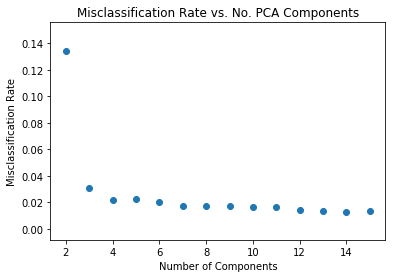

In [19]:
x, y = load_data('fashion-mnist')
x = x.reshape([70000, 28*28])

indices = []
for item in np.where(y==4)[0]:
    indices.append(item)
for item in np.where(y==8)[0]:
    indices.append(item)

x = x[indices,:]
y = y[indices]

#Subtracting the Mean
avgimg = x.mean(0)
cimages = np.subtract(x, avgimg)

misClass = []
for i in range(2,16):
    #Running the PCA
    pca = PCA(i).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i, 28, 28))

    #Writing Data on New PCA Axes
    pcs = pca.fit_transform(cimages)

    logReg = LogisticRegression(solver='lbfgs').fit(pcs, y)
    misClass.append(1-logReg.score(pcs,y))
    
plt.scatter(range(2,16),misClass)
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. No. PCA Components')
plt.show()

Similar to our misclassification plot with the 4's and 9's, we see a decreasing misclassification rate as we add more components, since these account for more variability and thus improve our predictions. Since handbags and coats are quite different, we see the error approaching 2%, which is much better than previously achieved in the 4's and 9's example.

## Part (e)

Follow the same procedure as in Parts (b) and (c) with the faces data instead of MNIST. This time, however, build a model that can classify whether an image is of George W. Bush ($y=3$) someone else. Create a variable that takes the value $1$ when the image is of George W. Bush and $0$ when it is not, and use this to train each Logistic Regression model after projecting onto the first $k$ principal components. Create a plot of misclassification rate as a function of $k$, letting $k$ vary between 2 and 30. Then, show training examples that are misclassified for the $k=30$ model.


In [20]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
y = lfw_people.target

lfw_people.target_names #George Bush is index 3

ans = []
for item in y:
    if item == 3:
        ans.append(1)
    else:
        ans.append(0)

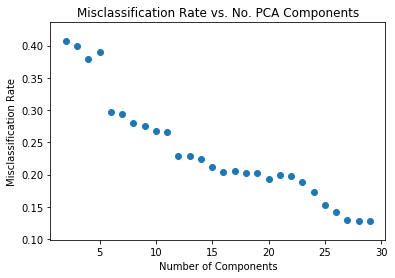

In [21]:
#Subtracting the Mean
avgimg = X.mean(0)
cimages = np.subtract(X, avgimg)

misClass = []
for i in range(2,30):
    #Running the PCA
    pca = PCA(i).fit(cimages)
    principal_vectors = pca.components_
    principal_vectors = principal_vectors.reshape((i, 50, 37))

    #Writing Data on New PCA Axes
    pcs = pca.fit_transform(cimages)

    logReg = LogisticRegression(solver='lbfgs').fit(pcs, ans)
    misClass.append(1-logReg.score(pcs,ans))
    
plt.scatter(range(2,30),misClass)
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. No. PCA Components')
plt.show()

Again we see a steadily decreasing error rate, although people are much more difficult to differentiate than coats and bags, or 4's and 9's, thus we see a nearly 12-13% error.

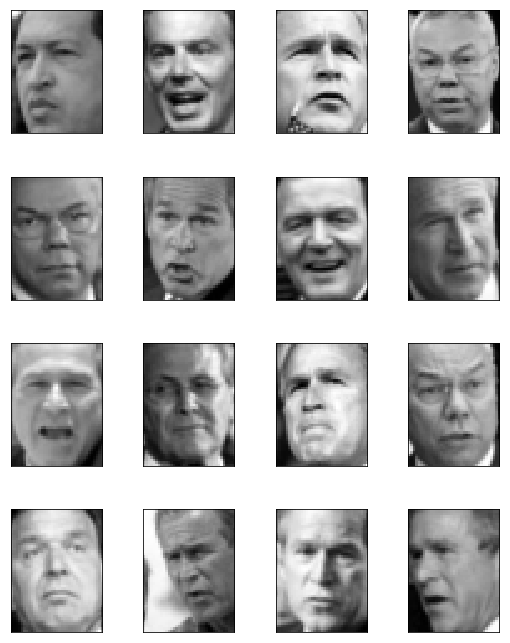

In [22]:
#Running the PCA
pca = PCA(30).fit(cimages)
principal_vectors = pca.components_
principal_vectors = principal_vectors.reshape((30, 50, 37))

#Writing Data on New PCA Axes
pcs = pca.fit_transform(cimages)

logReg = LogisticRegression(solver='lbfgs').fit(pcs, ans)
logPred = logReg.predict(pcs)

misclass = [index for index,value in enumerate(y==logPred) if value==False]

# The following code will display the images that are misclassified
plt.figure(figsize=(1.8 * 4, 2.4 * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[misclass[i]].reshape((50, 37)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

We see the model failed to classify some images of Bush as Bush, and some classified other politicians as Bush, which is understandable given that in some pictures his mouth is open or weirdly shaped, and there are a number of facial expressions that could easily throw the model off.